# SMCN for AR prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl

from ucn.models import SMCN
from src.trainer import SMCNTrainer
from src.dataset import ARMADataset, ARMAInitDataset

%load_ext autoreload
%autoreload 2

!rm -r lightning_logs/*

zsh:1: no matches found: lightning_logs/*


In [2]:
def plot_range(array, label=None):
    mean = array.mean(axis=-1)
    std = array.std(axis=-1)

    plt.plot(mean, label=label)
    # plt.fill_between(np.arange(len(array)), mean - std, mean + std, alpha=.3)
    plt.fill_between(np.arange(len(array)), array.min(axis=-1), array.max(axis=-1), alpha=.3)
    
def compare_stuff(model):
    print("Sigma_x:\t", model.sigma_x.diag().detach().numpy().squeeze().round(2), f"\t({sigma_x})")
    print("Sigma_y:\t", model.sigma_y.diag().detach().numpy().squeeze().round(2), f"\t({sigma_y})")
    print("a:\t\t", model._g._linear.weight.detach().numpy().squeeze().round(2), f"\t({b})")
    print("b:\t\t", model._f._linear.weight.detach().numpy().squeeze().round(2), "\t(1)")
    
def compute_train_loss(model, dataloader):
    running_loss = 0
    for u, y in dataloader:
        u = u.transpose(0, 1)
        y = y.transpose(0, 1)
        
        running_loss += model.compute_cost(u=u, y=y).item()
    return running_loss / len(dataloader.dataset)

## Generate ARMA model and observations

In [3]:
b = 0.75

sigma_x = 0.2
sigma_y = 0.6

n_obs = 10000

In [4]:
T = 25
n_samples = 1000

x_arma = []
for n_s in range(n_samples):
    x_arma.append([np.random.multivariate_normal((0,), np.diag([sigma_x]), size=1).item()])
    for k in range(T-1):
        x_arma[-1].append( b * x_arma[-1][-1] + np.random.multivariate_normal((0,), np.diag([sigma_x]), size=1).item())
x_arma = np.array(x_arma)

y_arma = x_arma + np.random.multivariate_normal((0,),
                                                np.diag([sigma_y]),
                                                size=x_arma.shape).squeeze()

Text(0.5, 1.0, 'ARMA model')

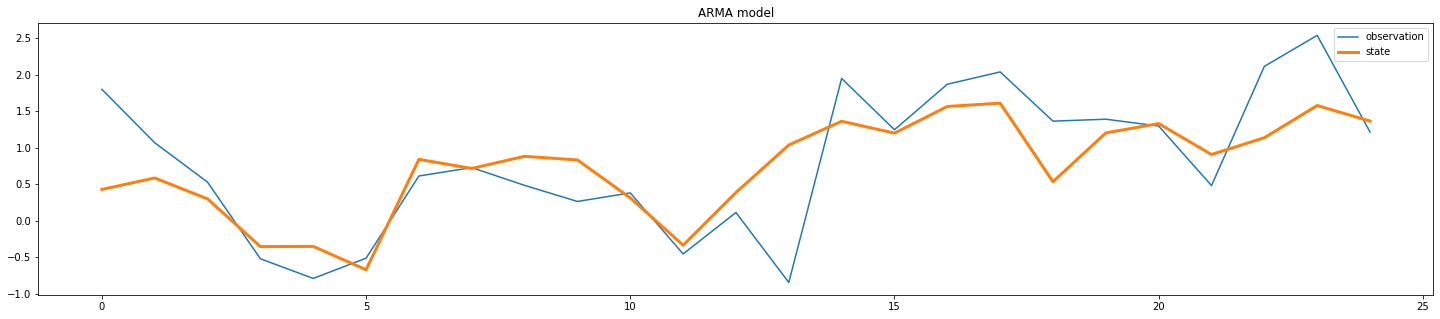

In [5]:
idx = np.random.randint(n_samples)

plt.figure(figsize=(25, 5))
plt.plot(y_arma[idx], label='observation')
plt.plot(x_arma[idx], lw=3, label='state')
plt.legend()
plt.title('ARMA model')

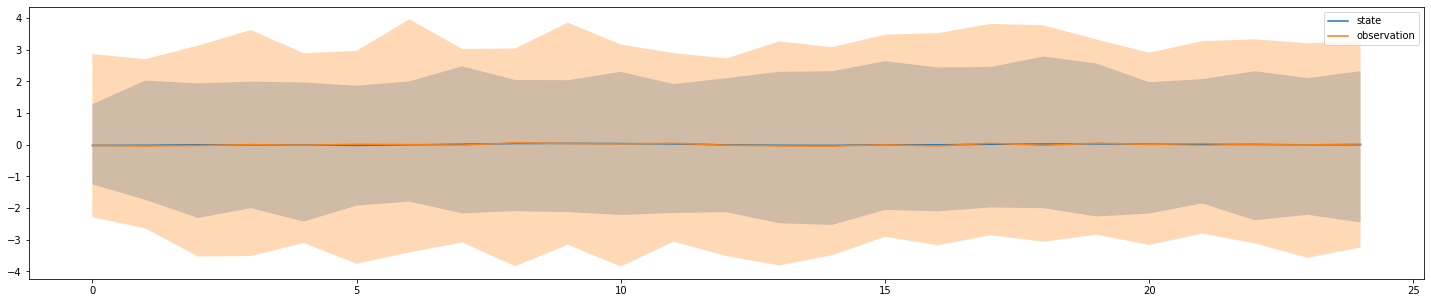

In [6]:
plt.figure(figsize=(25, 5))
plot_range(x_arma.T, label="state")
plot_range(y_arma.T, label="observation")
plt.legend()

## SMCN Model

In [7]:
d_emb = 1
d_out = 1
N = 100

model = SMCN(d_emb, d_out, n_particles=N)

## Training

#### Dataset

In [8]:
batch_size = 8
epochs = 30

dataset = ARMAInitDataset(y_arma,
                      torch.zeros(y_arma.shape))
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        num_workers=4,
                        shuffle=True
                       )

## Training from random parameters

In [9]:
compare_stuff(model)

train_model = SMCNTrainer(model)
trainer = pl.Trainer(max_epochs=epochs, gpus=0)
trainer.fit(train_model, dataloader)

compare_stuff(model)

Sigma_x:	 0.2 	(0.2)
Sigma_y:	 0.94 	(0.6)
a:		 0.35 	(0.75)
b:		 0.56 	(1)


GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/home/mrmojo/Code/these/uncertaintyQuantification/.env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name   | Type | Params
--------------------------------
0 | _model | SMCN | 4     
--------------------------------
4         Trainable params
0         Non-trainable params
4         Total params


Epoch 29: 100%|██████████| 125/125 [00:06<00:00, 20.74it/s, loss=1.35, v_num=0]
Sigma_x:	 0.09 	(0.2)
Sigma_y:	 0.59 	(0.6)
a:		 0.74 	(0.75)
b:		 1.53 	(1)


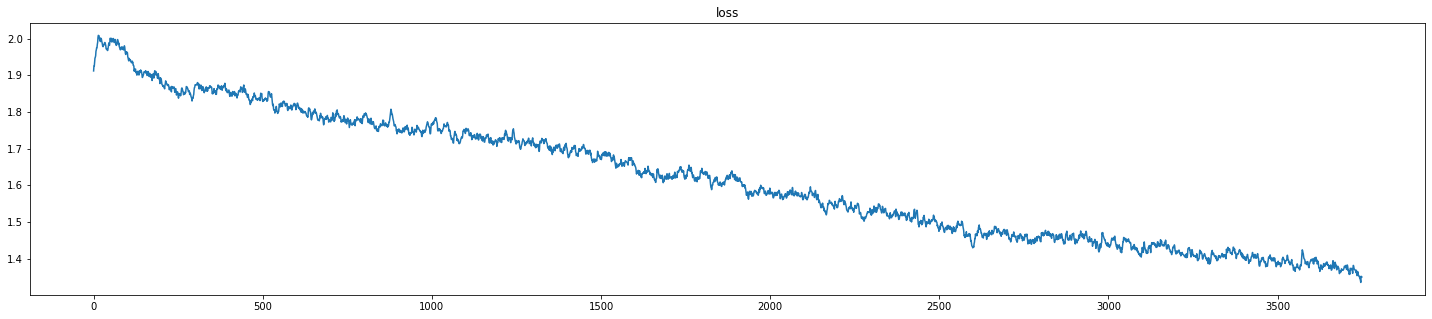

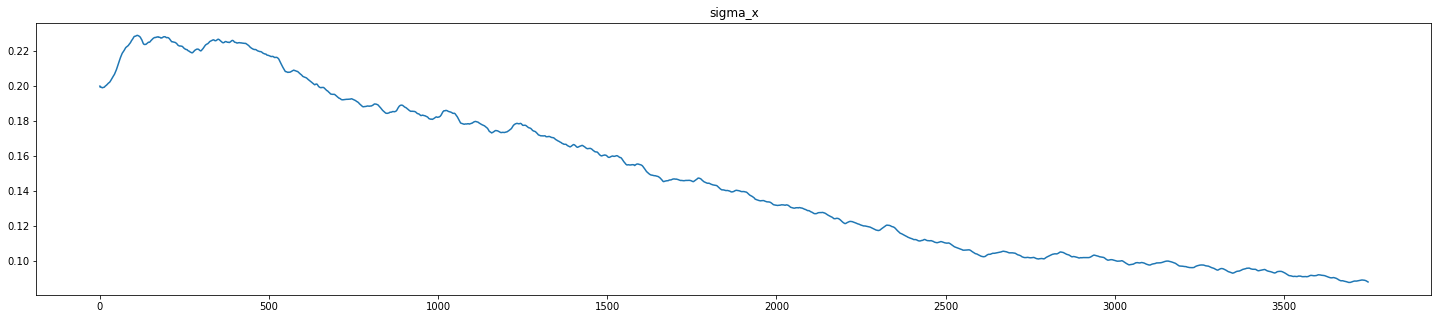

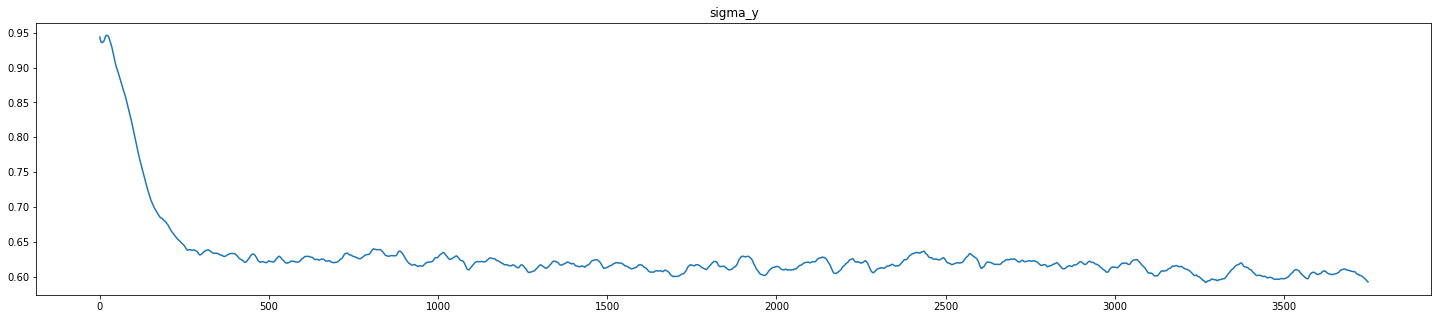

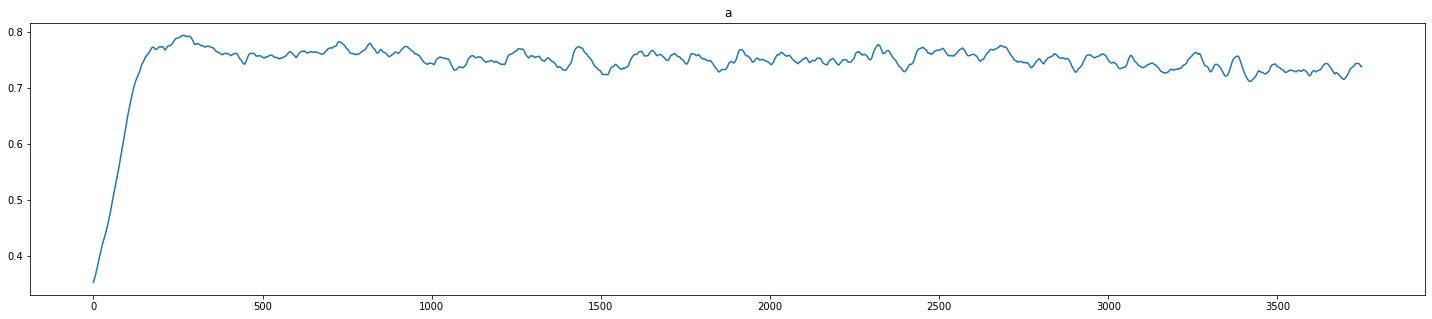

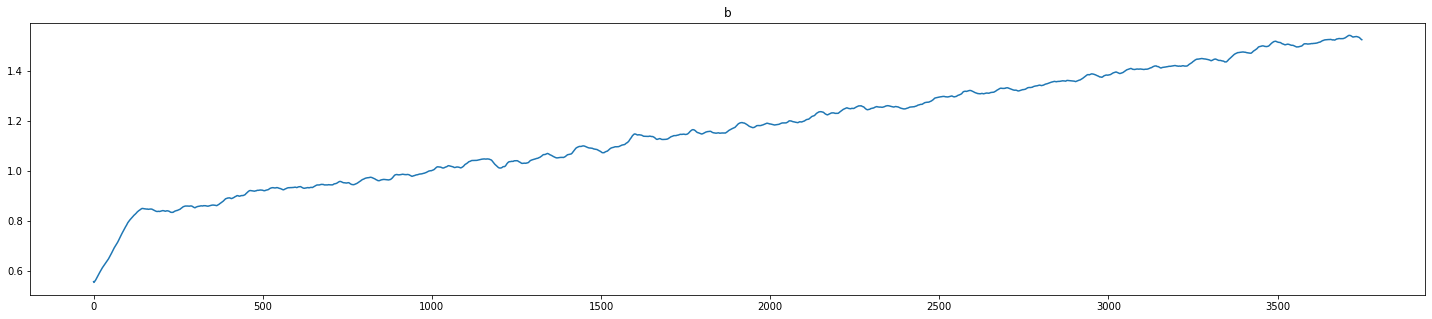

In [10]:
for key, values in train_model._hist.items():
    plt.figure(figsize=(25, 5))
    plt.plot(values)
    plt.title(key)

In [11]:
loss = compute_train_loss(model, dataloader)
print(f"Loss: {loss}")

Loss: 0.2605212378501892


## Training from optimal parameters

In [12]:
model = SMCN(d_emb, d_out, n_particles=N)
model._sigma_x.data = torch.log(torch.Tensor([[sigma_x]]))
model._sigma_y.data = torch.log(torch.Tensor([[sigma_y]]))

model._f._linear.weight.data = torch.Tensor([[1.]])
model._g._linear.weight.data = torch.Tensor([[b]])

In [13]:
compare_stuff(model)

train_model = SMCNTrainer(model)
trainer = pl.Trainer(max_epochs=epochs, gpus=0)
trainer.fit(train_model, dataloader)

compare_stuff(model)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores


Sigma_x:	 0.2 	(0.2)
Sigma_y:	 0.6 	(0.6)
a:		 0.75 	(0.75)
b:		 1.0 	(1)



  | Name   | Type | Params
--------------------------------
0 | _model | SMCN | 4     
--------------------------------
4         Trainable params
0         Non-trainable params
4         Total params


Epoch 29: 100%|██████████| 125/125 [00:05<00:00, 22.33it/s, loss=1.09, v_num=1]
Sigma_x:	 0.05 	(0.2)
Sigma_y:	 0.63 	(0.6)
a:		 0.77 	(0.75)
b:		 1.86 	(1)


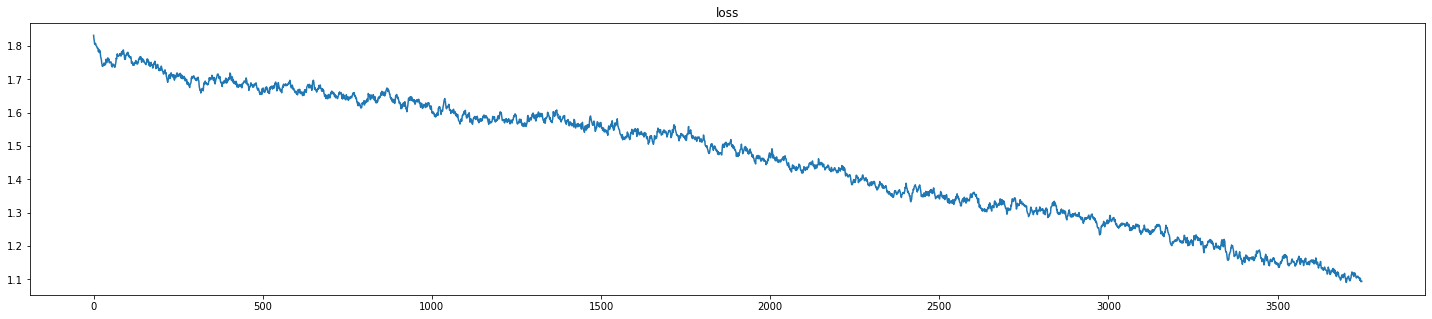

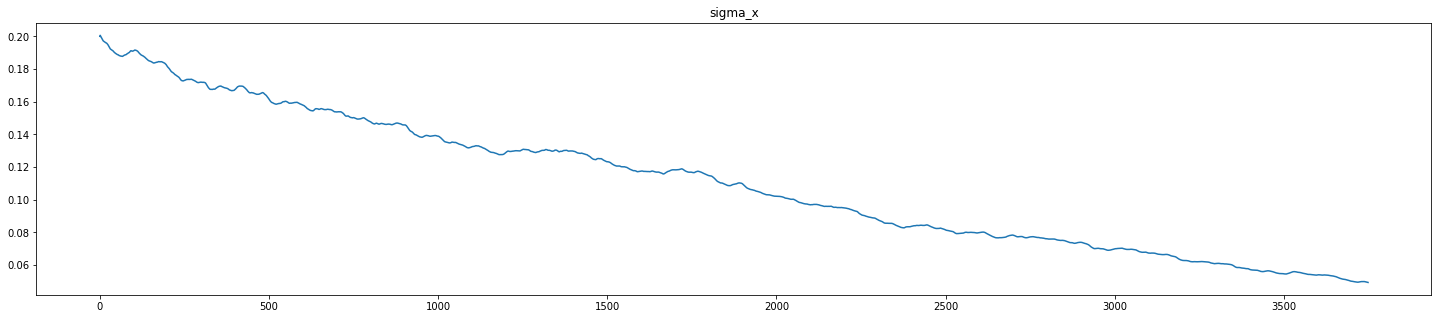

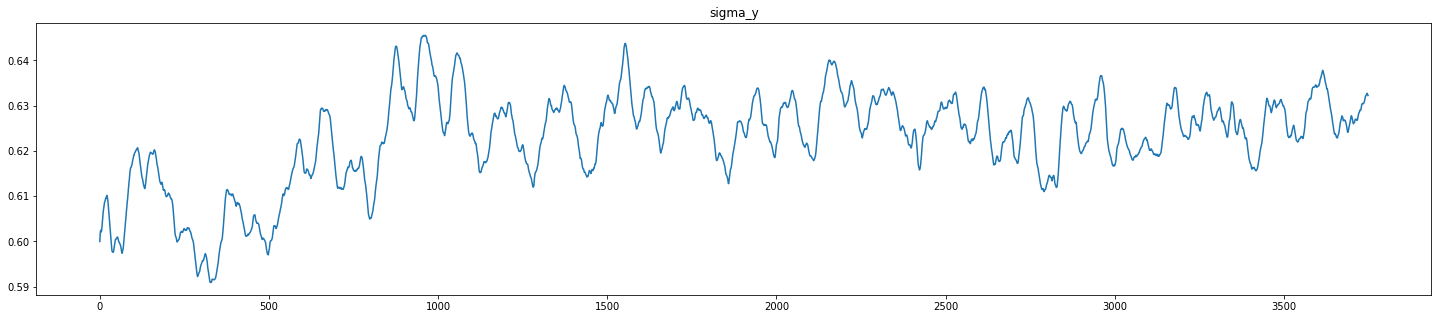

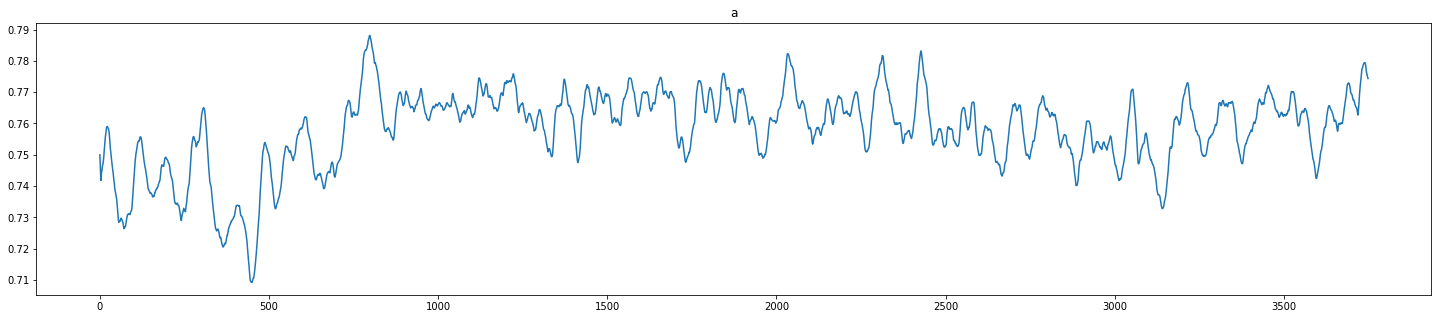

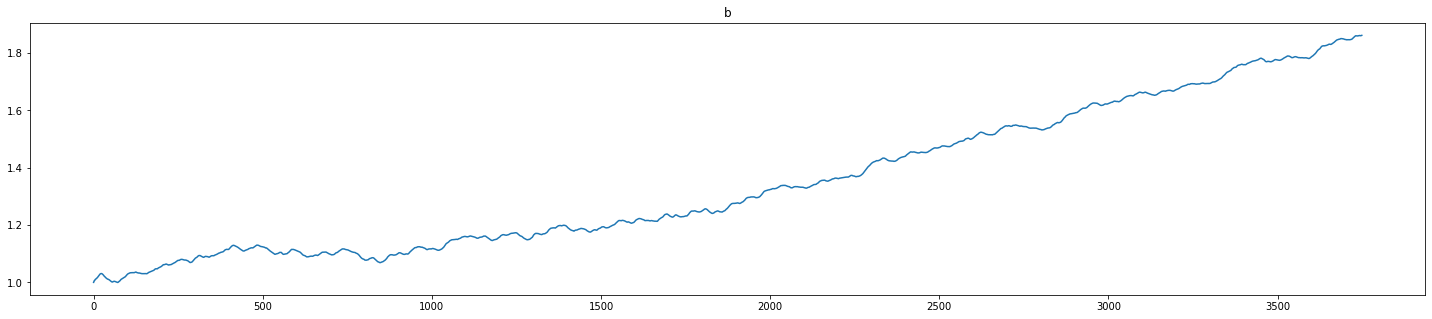

In [14]:
for key, values in train_model._hist.items():
    plt.figure(figsize=(25, 5))
    plt.plot(values)
    plt.title(key)

In [15]:
loss = compute_train_loss(model, dataloader)
print(f"Loss: {loss}")

Loss: 0.21897485744953155


## Le probleme

In [16]:
compare_stuff(model)
compute_train_loss(model, dataloader)

Sigma_x:	 0.05 	(0.2)
Sigma_y:	 0.63 	(0.6)
a:		 0.77 	(0.75)
b:		 1.86 	(1)


0.2173346503973007

In [17]:
model._sigma_x.data = torch.cholesky(torch.Tensor([[sigma_x]]))
model._sigma_y.data = torch.cholesky(torch.Tensor([[sigma_y]]))
model._f._linear.weight.data = torch.Tensor([[1.]])
model._g._linear.weight.data = torch.Tensor([[b]])

compare_stuff(model)
compute_train_loss(model, dataloader)

Sigma_x:	 1.56 	(0.2)
Sigma_y:	 2.17 	(0.6)
a:		 0.75 	(0.75)
b:		 1.0 	(1)


0.34089425110816957

## Visualization

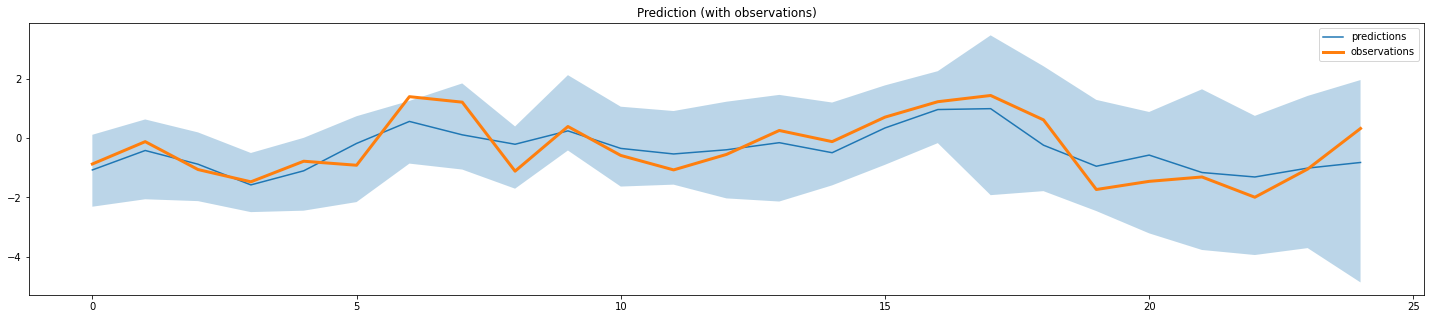

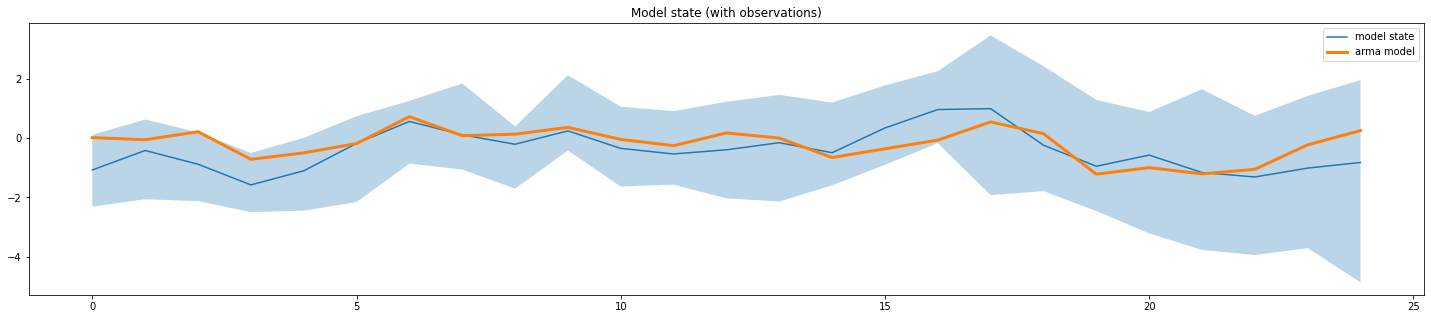

In [18]:
# Sample random time index
idx = np.random.randint(len(x_arma))
x = x_arma[idx]#:idx+T]
y = y_arma[idx]#:idx+T]
u = torch.zeros((T, 1, d_emb))

# Run inference with observations
with torch.no_grad():
    netout = model(u, noise=True, y=torch.Tensor(y).view(-1, 1))

netout = model.smooth_pms(netout, model.I)
particules = model.smooth_pms(model.particules, model.I)

netout = netout.detach().numpy().squeeze()
particules = particules.detach().numpy().squeeze()

plt.figure(figsize=(25, 5))
plot_range(netout, label='predictions')
plt.plot(y, lw=3, label='observations')
plt.title('Prediction (with observations)')
plt.legend()

plt.figure(figsize=(25, 5))
plot_range(particules, label='model state')
plt.plot(x, lw=3, label='arma model')
plt.title('Model state (with observations)')
plt.legend()

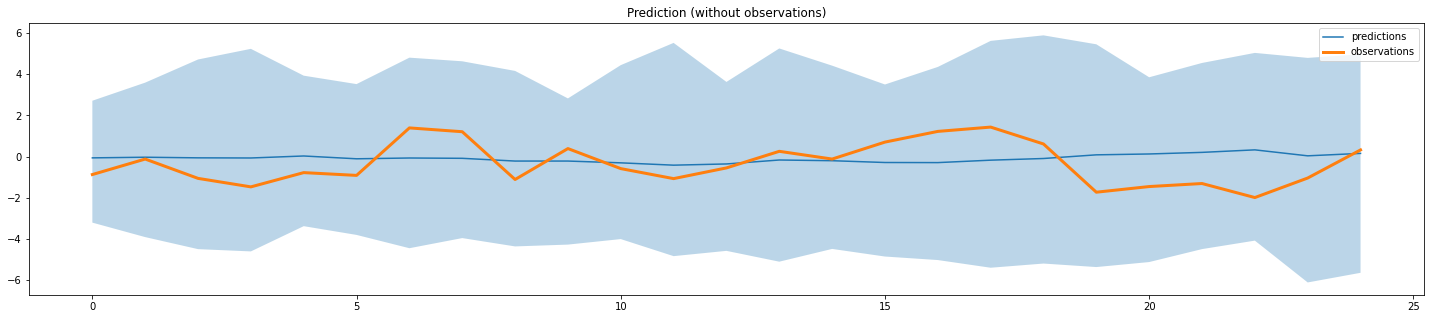

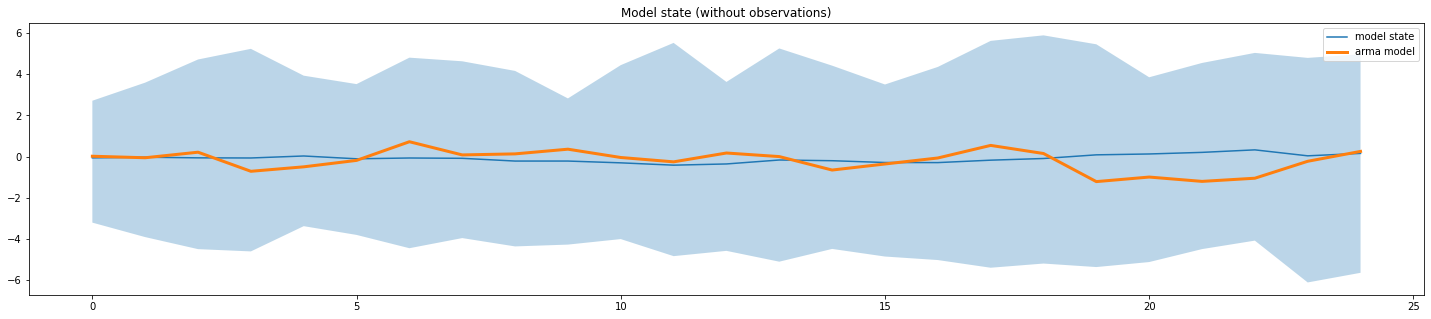

In [19]:
# Run inference withtout observation
with torch.no_grad():
    netout = model(u, noise=True)

netout = netout.detach().numpy().squeeze()
particules = model.particules.detach().numpy().squeeze()

plt.figure(figsize=(25, 5))
plot_range(netout, label='predictions')
plt.plot(y, lw=3, label='observations')
plt.title('Prediction (without observations)')
plt.legend()

plt.figure(figsize=(25, 5))
plot_range(particules, label='model state')
plt.plot(x, lw=3, label='arma model')
plt.title('Model state (without observations)')
plt.legend()